In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# the original infoNCE objective

def infoNCE_labeled(x1,x2,y,tau):
    assert(len(y)==x1.shape[0])
    assert(len(y)==x2.shape[0])
    x1n = x1/np.sqrt(np.sum(x1**2,axis=1,keepdims=True))
    x2n = x2/np.sqrt(np.sum(x2**2,axis=1,keepdims=True))

    C = (x1n@x2n.T)/tau
    S = np.exp(C)
    return  -0.5*np.mean( np.diagonal(C)-np.log(np.mean(S,axis=1) ))-0.5*np.mean( np.diagonal(C)-np.log(np.mean(S,axis=0) ))


def infoNCE_labeled_loss(x1,x2,y,tau):
    assert(len(y)==x1.shape[0])
    assert(len(y)==x2.shape[0])
    x1n = x1/np.sqrt(np.sum(x1**2,axis=1,keepdims=True))
    x2n = x2/np.sqrt(np.sum(x2**2,axis=1,keepdims=True))

    D = (2-2*(x1n@x2n.T))
    S = np.exp(-D/2/tau)
    return  0.5/tau*np.mean( np.diagonal(D) +2*tau*np.log(np.mean(S,axis=1) ))#



# the supervised contrastive learning
def supervised_contrastive(x1,x2,y,tau):
    x1n = x1/np.sqrt(np.sum(x1**2,axis=1,keepdims=True))
    x2n = x2/np.sqrt(np.sum(x2**2,axis=1,keepdims=True))
    xn = np.vstack((x1n,x2n))
    yn = np.tile(y,2)
    C = xn@xn.T/tau
    S = np.exp(C)
    mask = 1*(yn[:,np.newaxis]==yn[np.newaxis,:])
    np.fill_diagonal(mask,0)
    np.fill_diagonal(S,0)
    log_prob = C - np.log(np.sum(S,axis=1,keepdims=True))
    return  -np.mean( np.sum(mask*log_prob,axis=1)/np.sum(mask,axis=1))




In [ ]:
#   # Create a mask for positive pairs
#     labels = labels.contiguous().view(-1, 1)
#     mask = torch.eq(labels, labels.T).float().to(device)

#     # Exclude self-contrast
#     logits_mask = torch.scatter(
#         torch.ones_like(mask),
#         1,
#         torch.arange(batch_size).view(-1, 1).to(device),
#         0
#     )
#     mask = mask * logits_mask
#     # Compute log_prob
#     exp_logits = torch.exp(similarity_matrix) * logits_mask
#     log_prob = similarity_matrix - torch.log(exp_logits.sum(1, keepdim=True))

#     # Compute mean of log-likelihood over positive pairs
#     mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

In [ ]:

# MMD
def MMD(x1,x2,y,tau,unbiased=False):
    x1n = x1/np.sqrt(np.sum(x1**2,axis=1,keepdims=True))
    x2n = x2/np.sqrt(np.sum(x2**2,axis=1,keepdims=True))
    xn = np.vstack((x1n,x2n))
    Kx = x1n@x1n.T
    Ky = x2n@x2n.T
    Kxy = x1n@x2n.T

    N = len(y)
    mask = np.ones((N,N))
    o_mask = mask.copy()
    np.fill_diagonal(mask,0)

    MMD2 = (np.mean(Kx*mask) + np.mean(Ky*mask))*N/(N-1) - 2*np.mean(Kxy*o_mask)

    if unbiased:
        MMD2 = np.mean( np.sum(Kx*mask + Ky*mask,axis=1)/np.sum(mask,axis=1) - 2*np.sum(Kxy*o_mask,axis=1)/np.sum(o_mask,axis=1))
    else:
        MMD2 = np.mean( np.sum((Kx+Ky-2*Kxy)*o_mask,axis=1)/np.sum(o_mask,axis=1))
    return  np.sqrt(np.maximum(0,MMD2))



# MMD with joint a cosine based kernel
def supervised_MMD(x1,x2,y,tau,unbiased=False):
    x1n = x1/np.sqrt(np.sum(x1**2,axis=1,keepdims=True))
    x2n = x2/np.sqrt(np.sum(x2**2,axis=1,keepdims=True))
    xn = np.vstack((x1n,x2n))
    Kx = x1n@x1n.T
    Ky = x2n@x2n.T
    Kxy = x1n@x2n.T

    N = len(y)
    mask = 1*(y[:,np.newaxis]==y[np.newaxis,:])
    o_mask = mask.copy()
    np.fill_diagonal(mask,0)

    MMD2 = (np.mean(Kx*mask) + np.mean(Ky*mask))*N/(N-1) - 2*np.mean(Kxy*o_mask)

    if unbiased:
        MMD2 = np.mean( np.sum(Kx*mask + Ky*mask,axis=1)/np.sum(mask,axis=1) - 2*np.sum(Kxy*o_mask,axis=1)/np.sum(o_mask,axis=1))
    else:
        MMD2 = np.mean( np.sum((Kx+Ky-2*Kxy)*o_mask,axis=1)/np.sum(o_mask,axis=1))
    return  np.sqrt(np.maximum(0,MMD2))




In [ ]:

# ESW with joint
def EBSW(x1,x2,y,tau,L=1000):
    x1n = x1/np.sqrt(np.sum(x1**2,axis=1,keepdims=True))
    x2n = x2/np.sqrt(np.sum(x2**2,axis=1,keepdims=True))

    N = len(y)
    rng = np.random.default_rng(0)

    W = rng.standard_normal(size=(x1n.shape[1],L))
    W /= np.sqrt(np.sum(W**2,axis=0,keepdims=True))
    d= np.mean((np.sort(x1n@W,axis=0)-np.sort(x2n@W,axis=0))**2,axis=0) # sort is such that same label is always closest
    w = np.exp(d)
    w /= np.sum(w)
    return  np.sqrt(np.dot(w,d))

# ESW with joint
def supervised_EBSW(x1,x2,y,tau,L=1000):
    x1n = x1/np.sqrt(np.sum(x1**2,axis=1,keepdims=True))
    x2n = x2/np.sqrt(np.sum(x2**2,axis=1,keepdims=True))

    N = len(y)
    rng = np.random.default_rng(0)

    W = rng.standard_normal(size=(x1n.shape[1],L))
    W /= np.sqrt(np.sum(W**2,axis=0,keepdims=True))
    d= np.mean((np.sort(y[:,np.newaxis]+0.5*x1n@W,axis=0)-np.sort(y[:,np.newaxis]+0.5*x2n@W,axis=0))**2,axis=0) # sort is such that same label is always closest
    w = np.exp(d)
    w /= np.sum(w)
    return  np.sqrt(np.dot(w,d))




In [ ]:
# define the simplest scenario

theta = 0.5

x0 = np.array([1,0,0])
x1 = np.array([0,1,0])
x2 = np.array([0,np.cos(theta),np.sin(theta)])
X = np.vstack((x0,x1,x2))
p0 = 0.5
p1 = 0.25
p2 = 0.75

In [ ]:
X1 = np.vstack((x0,x0,x1,x2,x2))
X2 = np.vstack((x0,x0,x2,x2,x2))

print(supervised_MMD(X2,X1,np.array([0,0,1,1,1]),.1),supervised_MMD(X1,X1,np.array([0,0,1,1,1]),.1))

print(supervised_EBSW(X2,X1,np.array([0,0,1,1,1]),.1),supervised_EBSW(X1,X1,np.array([0,0,1,1,1]),.1))

0.1277588551971394 0.0
0.06459935312703365 0.0


In [ ]:
p0 = 0.5
p1 = 0.25
p2 = 0.75

N = 100
n_monte = 20
thetas = np.linspace(0,np.pi/2,100)
losses = [supervised_EBSW, supervised_MMD, EBSW, MMD, infoNCE_labeled,supervised_contrastive]
taus = np.logspace(-2,0,3)
loss_names = ['CC-EBSW', r'CC-MMD', 'EBSW', r'MMD',r'$\mathcal{L}_\text{info}$', r'$\mathcal{L}^\text{sup}_\text{out}$']
sets_of_taus = [[None], [None],[None], [None],taus,taus]


values = np.zeros((n_monte,len(thetas),len(losses),len(taus)))

for outer,theta in enumerate(thetas):
    x2 = np.array([0,np.cos(theta),np.sin(theta)])
    X = np.vstack((x0,x1,x2))

    rng = np.random.default_rng(0)
    for monte in range(n_monte):
        idx = rng.choice(3,size=N,p=[p0,(1-p0)*p1,(1-p0)*p2])
        y = 1*(idx>0)
        X1 = X[idx] # first copy
        idx1 = rng.choice(3,size=N,p=[0,p1,p2])
        X2 = X[idx1] # indpendent from class 1
        X2[y==0]=x0 # rewrite with class 0
        for i,loss in enumerate(losses):
            for j,tau in enumerate(sets_of_taus[i]):
                values[monte,outer,i,j] = loss(X1,X2,y,tau)



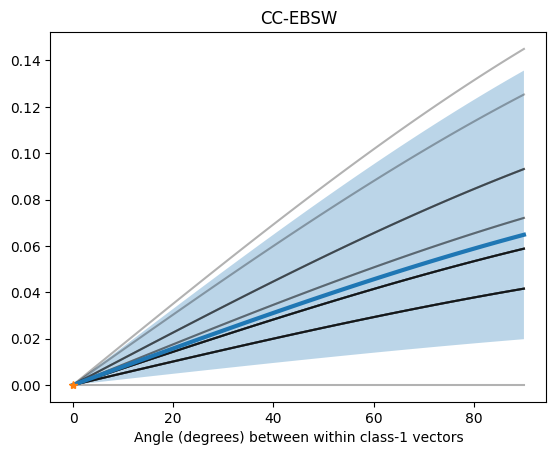

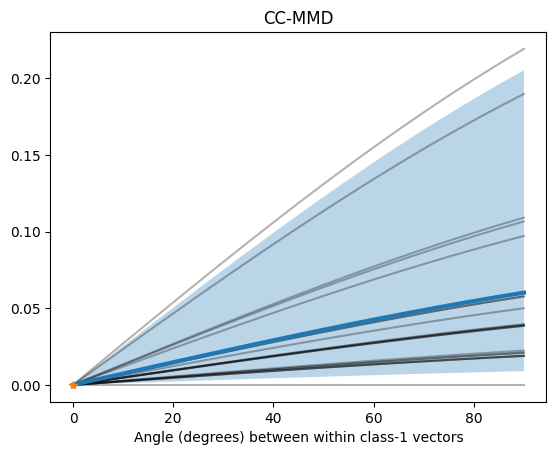

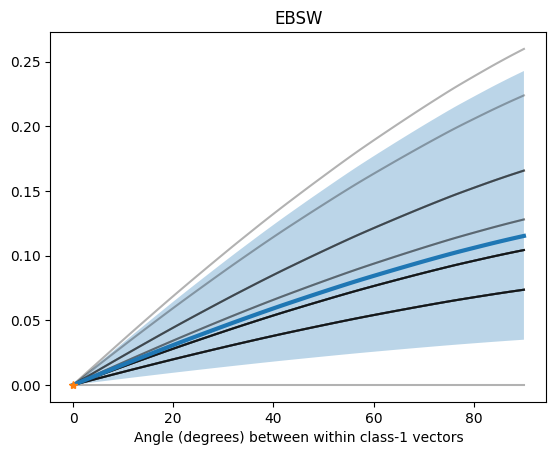

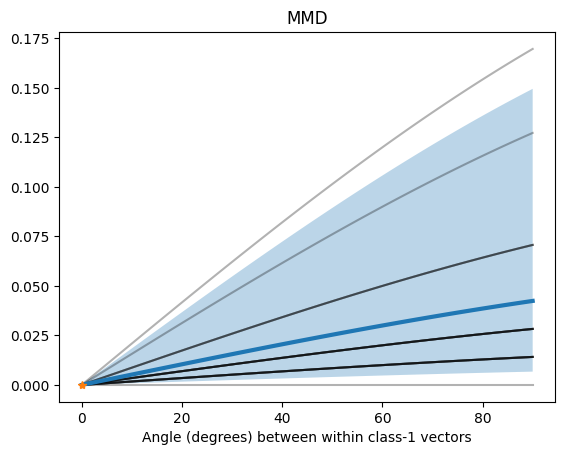

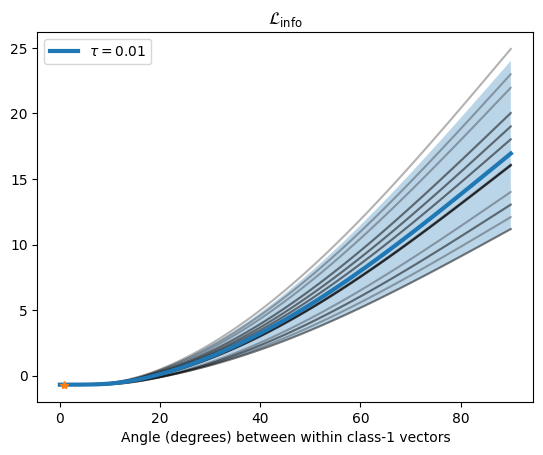

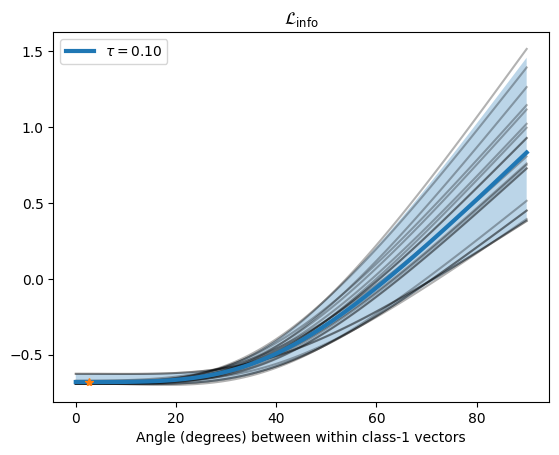

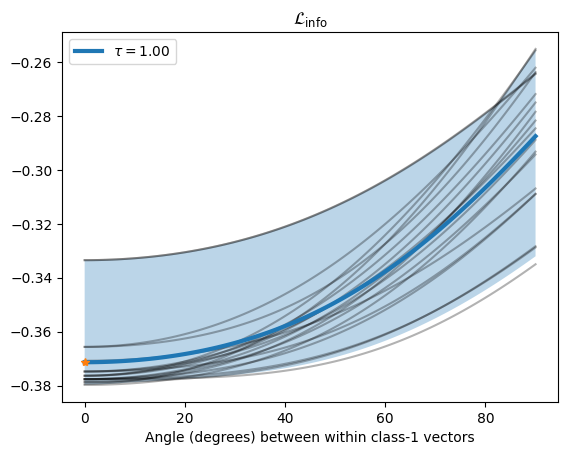

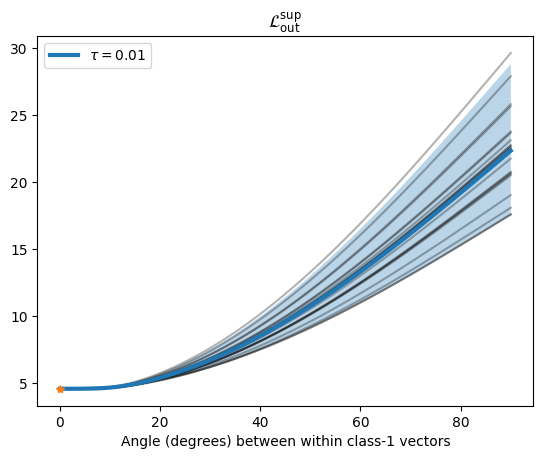

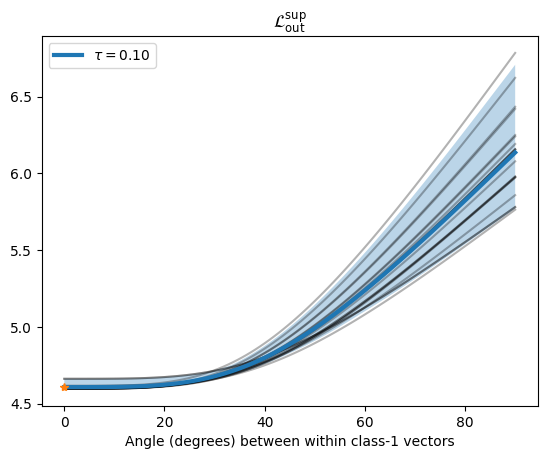

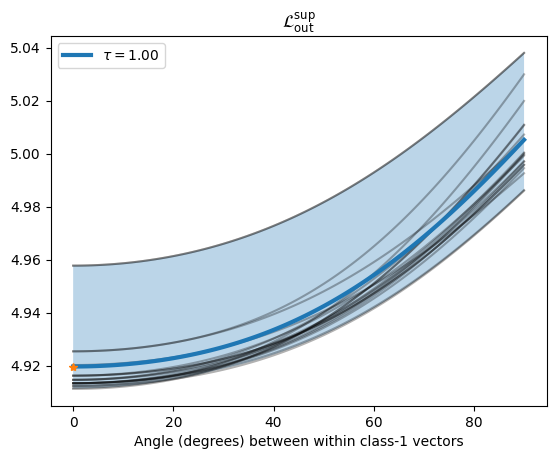

In [ ]:

for method_i,loss in enumerate(losses):
    for tau_j,tau in enumerate(sets_of_taus[method_i]):
        fig = plt.figure()
        v = np.mean(values[:,:,method_i,tau_j],axis=0).squeeze()

        plt.plot(180/np.pi*thetas,values[:,:,method_i,tau_j].T,'k',alpha=0.3)
        v = np.mean(values[:,:,method_i,tau_j],axis=0).squeeze()
        if tau is not None:
            plt.plot(180/np.pi*thetas,v,lw=3,label=r'$\tau=$'+f'{tau:.2f}')
            plt.legend()
        else:
            plt.plot(180/np.pi*thetas,v,lw=3)

        vl = np.quantile(values[:,:,method_i,tau_j],0.025,axis=0).squeeze()
        vu = np.quantile(values[:,:,method_i,tau_j],1-0.025,axis=0).squeeze()
        plt.fill_between(180/np.pi*thetas,vl,vu, alpha=0.3, label='95% Confidence Interval')
        plt.plot(180/np.pi*thetas[np.argmin(v)],np.min(v),'*')
        plt.xlabel('Angle (degrees) between within class-1 vectors')
        plt.title(loss_names[method_i])
        if ((loss_names[method_i]=='CC-EBSW') or (loss_names[method_i]=='CC-EBSW' )):
            plt.savefig(f"{method_i}_base3D.pdf")
        if tau==0.1:
            plt.savefig(f"{method_i}_{tau:.2f}_base3D.pdf")

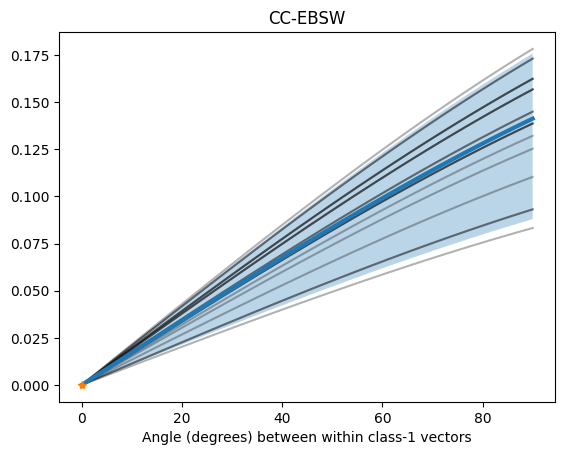

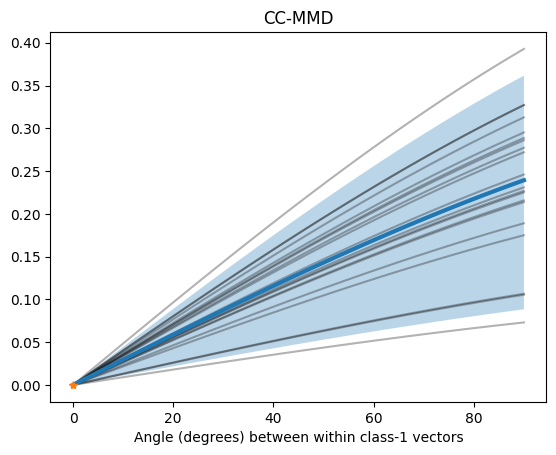

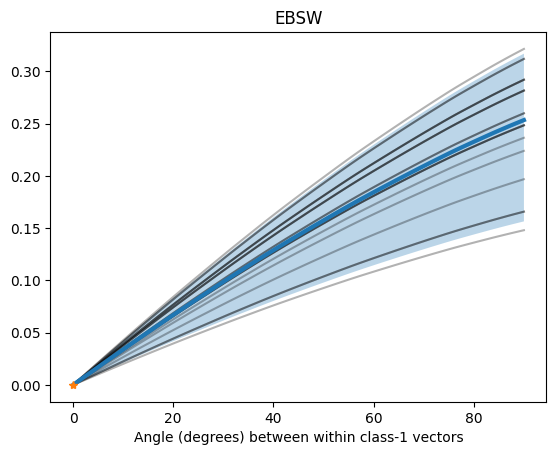

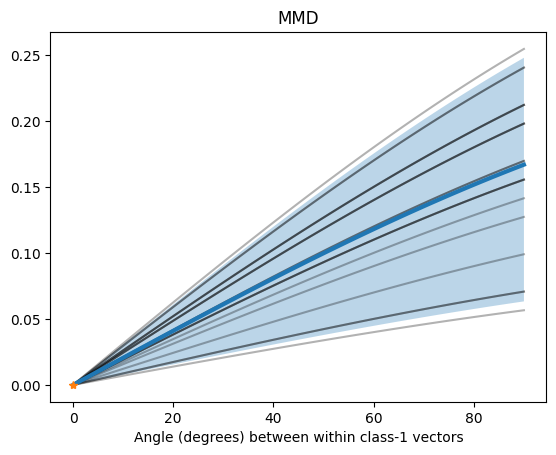

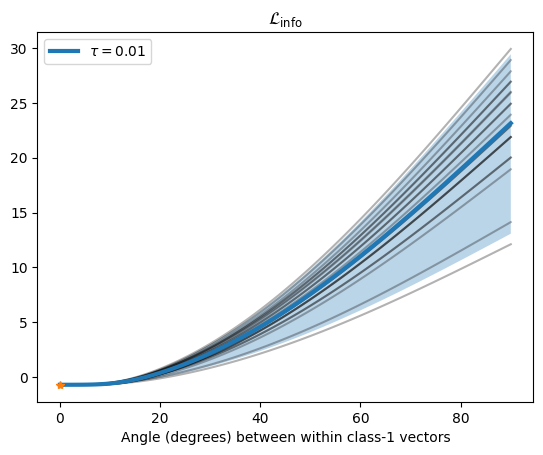

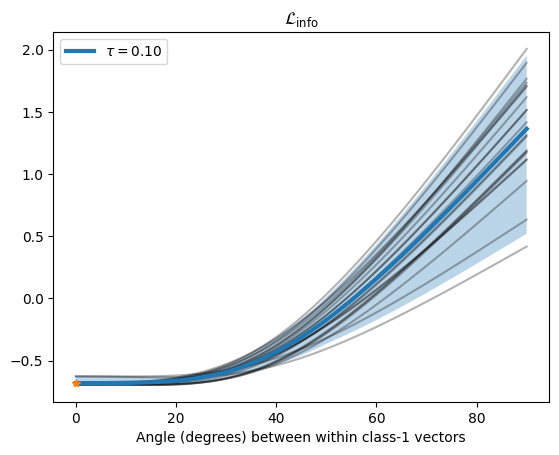

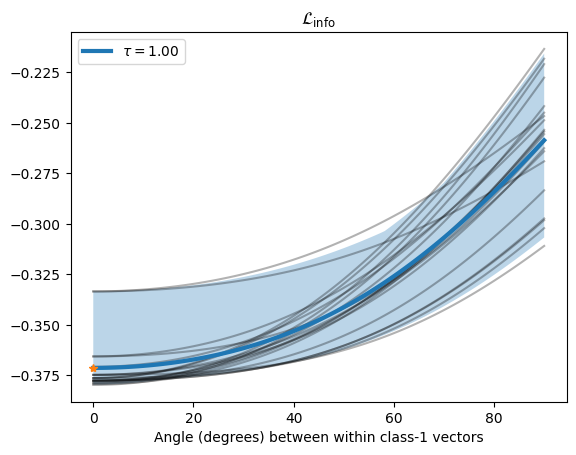

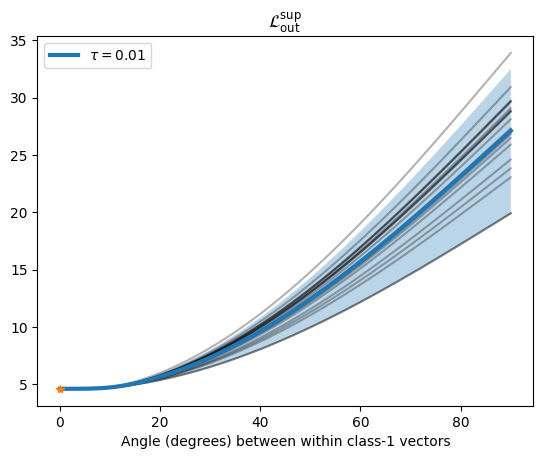

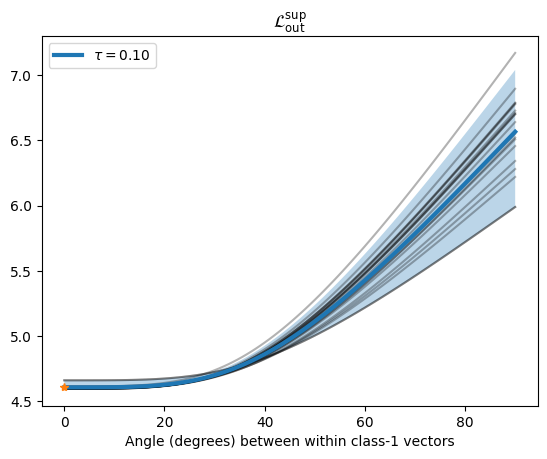

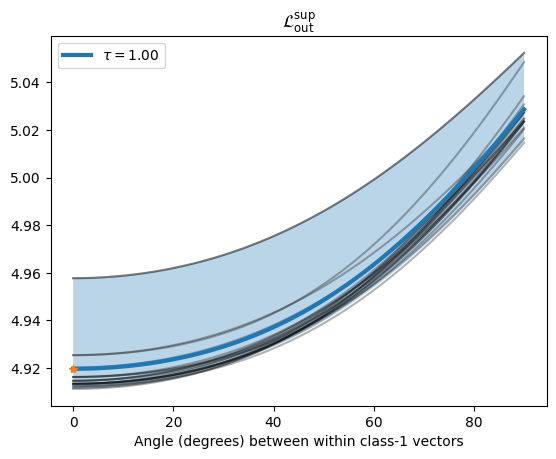

In [ ]:
#  imbalanced case
p0 = 0.5
p1 = 0.25
p2 = 0.75
p3 = 0.5

values = np.zeros((n_monte,len(thetas),len(losses),len(taus)))

for outer,theta in enumerate(thetas):
    x2 = np.array([0,np.cos(theta),np.sin(theta)])
    X = np.vstack((x0,x1,x2))

    rng = np.random.default_rng(0)
    for monte in range(n_monte):
        idx = rng.choice(3,size=N,p=[p0,(1-p0)*p1,(1-p0)*p2])
        y = 1*(idx>0)
        X1 = X[idx] # first copy
        idx1 = rng.choice(3,size=N,p=[0,p3,1-p3])
        X2 = X[idx1] # indpendent from class 1
        X2[y==0]=x0 # rewrite with class 0
        for i,loss in enumerate(losses):
            for j,tau in enumerate(sets_of_taus[i]):
                values[monte,outer,i,j] = loss(X1,X2,y,tau)


for method_i,loss in enumerate(losses):
    for tau_j,tau in enumerate(sets_of_taus[method_i]):
        fig = plt.figure()
        v = np.mean(values[:,:,method_i,tau_j],axis=0).squeeze()

        plt.plot(180/np.pi*thetas,values[:,:,method_i,tau_j].T,'k',alpha=0.3)
        v = np.mean(values[:,:,method_i,tau_j],axis=0).squeeze()
        if tau is not None:
            plt.plot(180/np.pi*thetas,v,lw=3,label=r'$\tau=$'+f'{tau:.2f}')
            plt.legend()
        else:
            plt.plot(180/np.pi*thetas,v,lw=3)

        vl = np.quantile(values[:,:,method_i,tau_j],0.025,axis=0).squeeze()
        vu = np.quantile(values[:,:,method_i,tau_j],1-0.025,axis=0).squeeze()
        plt.fill_between(180/np.pi*thetas,vl,vu, alpha=0.3, label='95% Confidence Interval')
        plt.plot(180/np.pi*thetas[np.argmin(v)],np.min(v),'*')
        plt.xlabel('Angle (degrees) between within class-1 vectors')
        plt.title(loss_names[method_i])


In [ ]:
# In this case the target is bimodal with fixed angle of 30 degrees
p0 = 0.5
p1 = 0.25
p2 = 0.75

fixed_angle = 30

x3 = np.array([0,np.cos(fixed_angle*np.pi/180),np.sin(fixed_angle*np.pi/180)])

values = np.zeros((n_monte,len(thetas),len(losses),len(taus)))

for outer,theta in enumerate(thetas):
    x2 = np.array([0,np.cos(theta),np.sin(theta)])
    X_source = np.vstack((x0,x1,x2))
    X_target = np.vstack((x0,x1,x3))


    rng = np.random.default_rng(0)
    for monte in range(n_monte):
        idx = rng.choice(3,size=N,p=[p0,(1-p0)*p1,(1-p0)*p2])
        y = 1*(idx>0)
        X1 = X_source[idx] # first copy
        idx1 = rng.choice(3,size=N,p=[0,p1,p2])
        X2 = X_target[idx1] # indpendent from class 1
        X2[y==0]=x0 # rewrite with class 0
        for i,loss in enumerate(losses):
            for j,tau in enumerate(sets_of_taus[i]):
                values[monte,outer,i,j] = loss(X1,X2,y,tau)



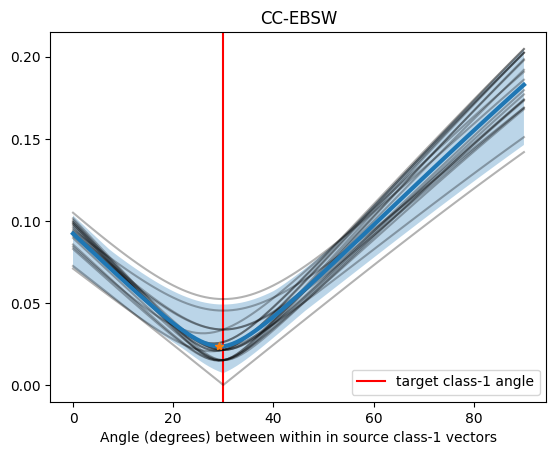

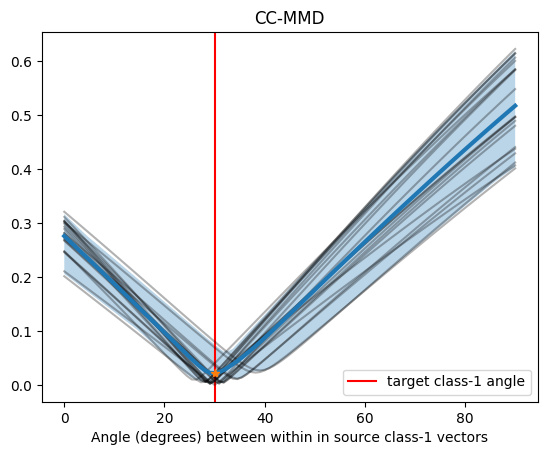

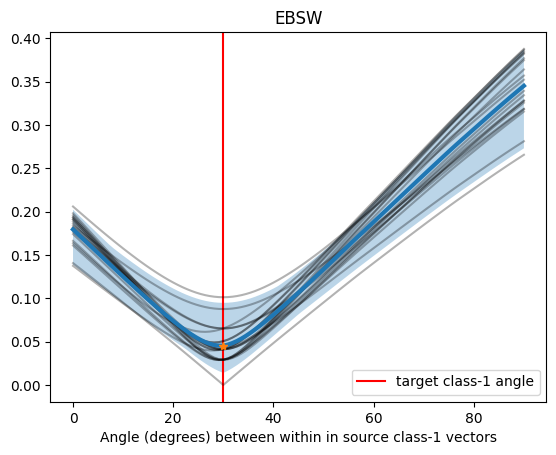

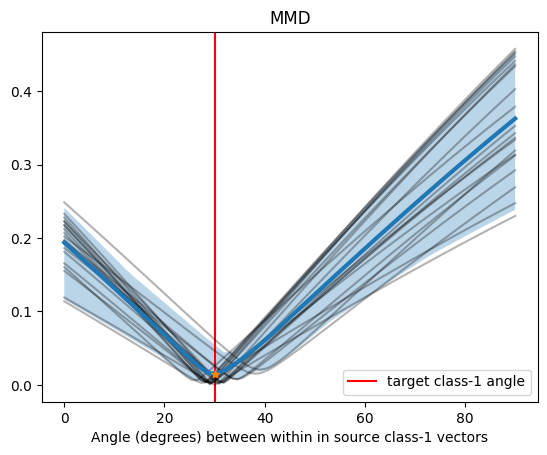

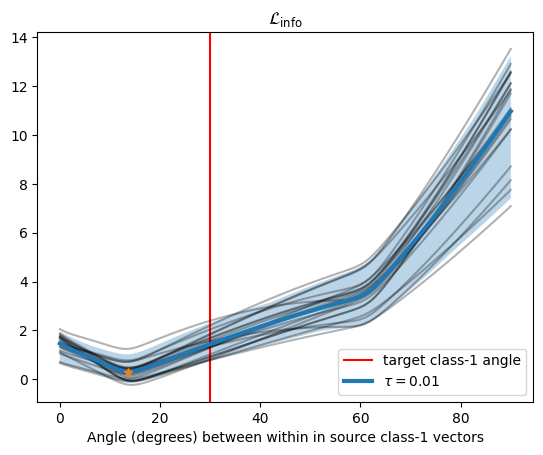

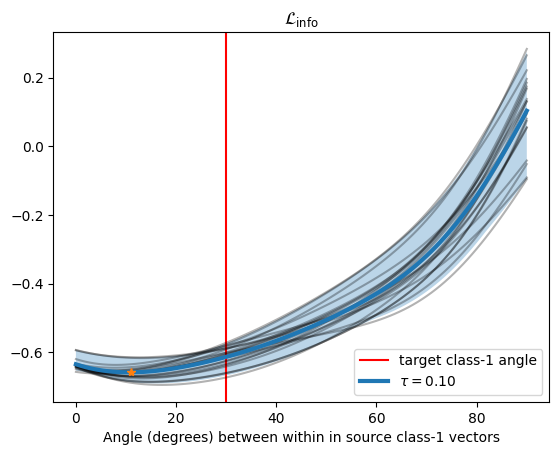

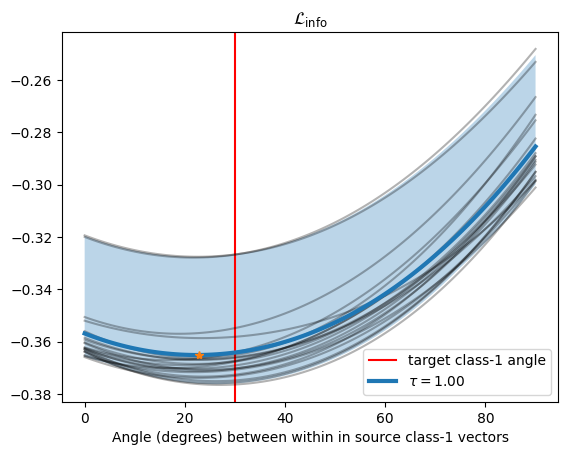

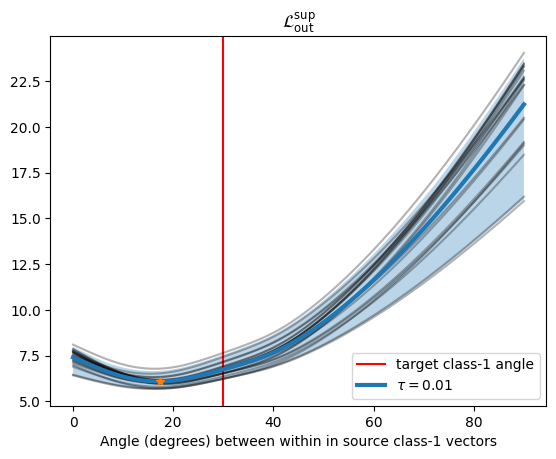

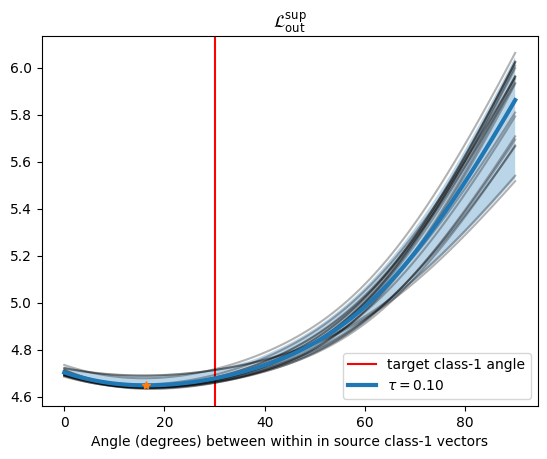

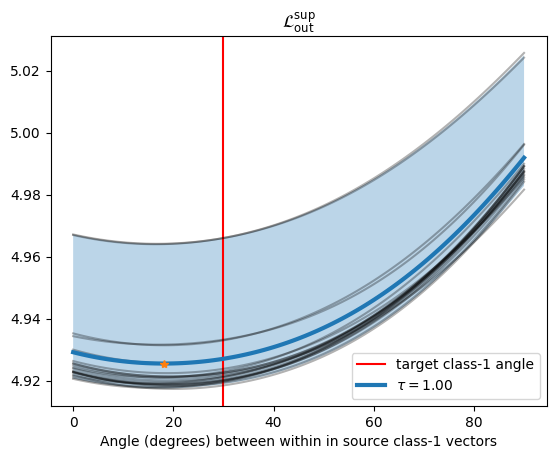

In [ ]:
for method_i,loss in enumerate(losses):
    for tau_j,tau in enumerate(sets_of_taus[method_i]):
        fig = plt.figure()
        v = np.mean(values[:,:,method_i,tau_j],axis=0).squeeze()
        plt.axvline(fixed_angle,color='r',label='target class-1 angle')

        plt.plot(180/np.pi*thetas,values[:,:,method_i,tau_j].T,'k',alpha=0.3)
        v = np.mean(values[:,:,method_i,tau_j],axis=0).squeeze()
        if tau is not None:
            plt.plot(180/np.pi*thetas,v,lw=3,label=r'$\tau=$'+f'{tau:.2f}')
        else:
            plt.plot(180/np.pi*thetas,v,lw=3)

        plt.legend()
        vl = np.quantile(values[:,:,method_i,tau_j],0.025,axis=0).squeeze()
        vu = np.quantile(values[:,:,method_i,tau_j],1-0.025,axis=0).squeeze()
        plt.fill_between(180/np.pi*thetas,vl,vu, alpha=0.3, label='95% Confidence Interval')
        plt.plot(180/np.pi*thetas[np.argmin(v)],np.min(v),'*')
        plt.xlabel('Angle (degrees) between within in source class-1 vectors')
        plt.title(loss_names[method_i])
        if ((loss_names[method_i]=='CC-EBSW') or (loss_names[method_i]=='CC-EBSW' )):
            plt.savefig(f"{method_i}_at30_3D.pdf")
        if tau==0.1:
            plt.savefig(f"{method_i}_{tau:.2f}_at30_3D.pdf")

In [ ]:
# In this case the target is bimodal with fixed angle of 30 degrees
# but the within class distribution is different between source and target
p0 = 0.5
p1 = 0.25
p2 = 0.75 # majority of source class-1 are adjustable
p3 = 0.5 # equal target

values = np.zeros((n_monte,len(thetas),len(losses),len(taus)))

for outer,theta in enumerate(thetas):
    x2 = np.array([0,np.cos(theta),np.sin(theta)])
    X_source = np.vstack((x0,x1,x2))
    X_target = np.vstack((x0,x1,x3))


    rng = np.random.default_rng(0)
    for monte in range(n_monte):
        idx = rng.choice(3,size=N,p=[p0,(1-p0)*p1,(1-p0)*p2])
        y = 1*(idx>0)
        X1 = X_source[idx] # first copy

        idx1 = rng.choice(3,size=N,p=[0,p3,1-p3])# target given class-1
        X2 = X_target[idx1] # indpendent from class 1
        X2[y==0]=x0 # rewrite with class 0
        for i,loss in enumerate(losses):
            for j,tau in enumerate(sets_of_taus[i]):
                values[monte,outer,i,j] = loss(X1,X2,y,tau)



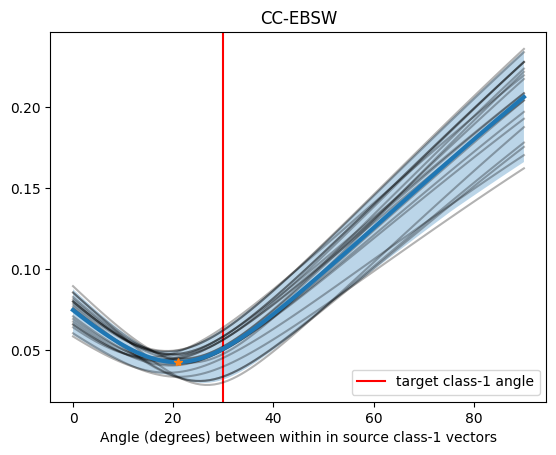

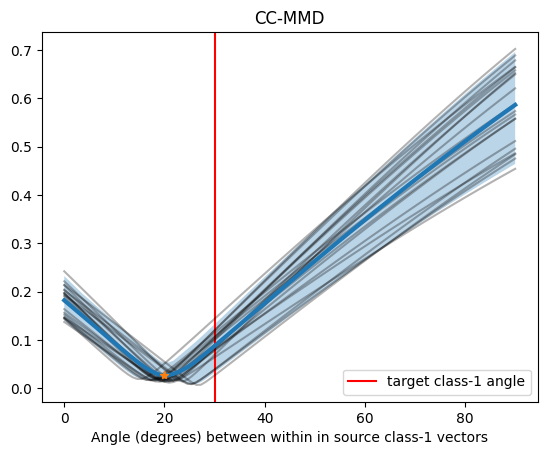

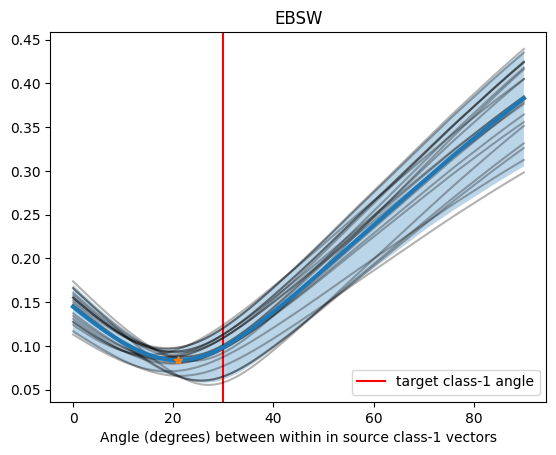

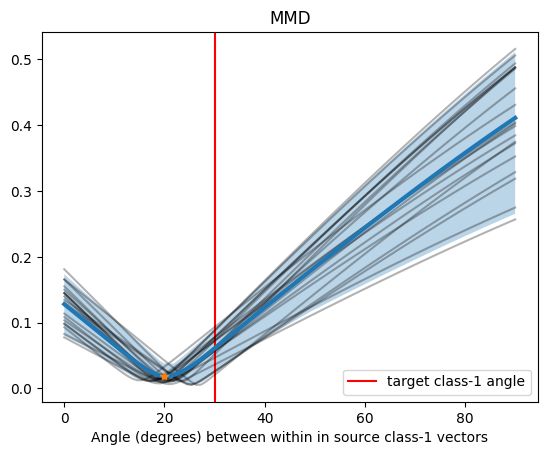

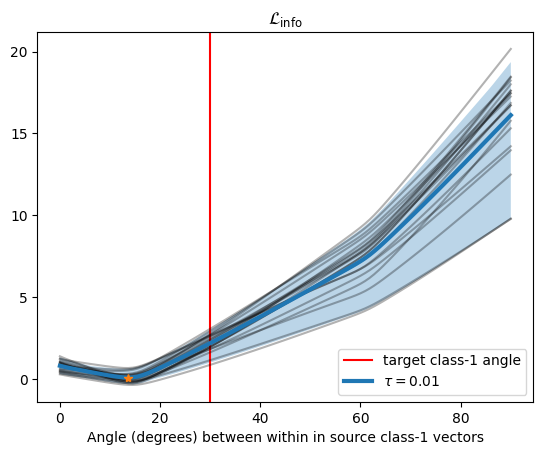

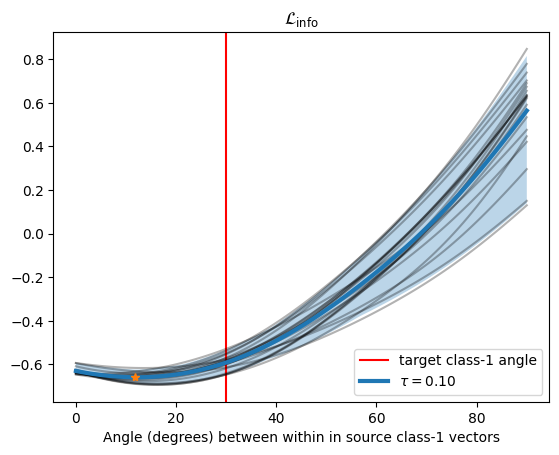

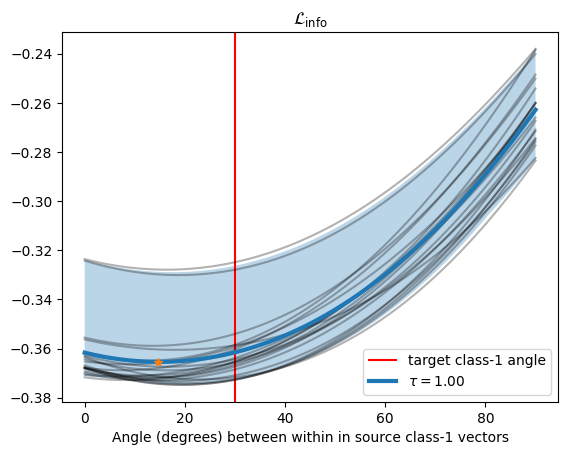

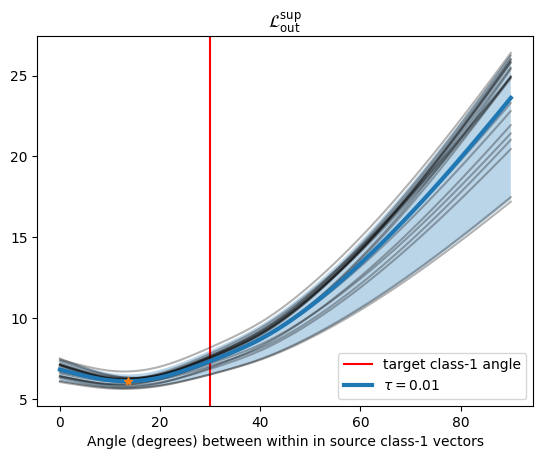

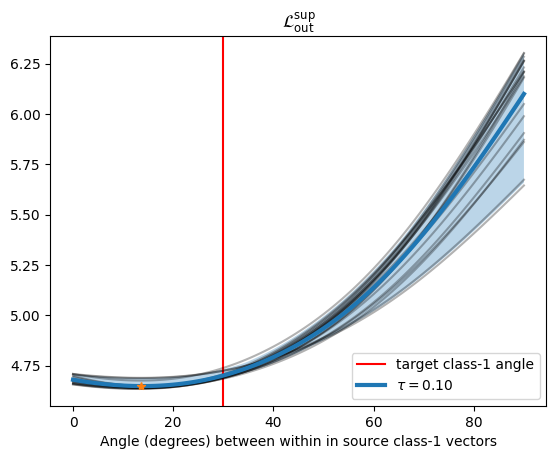

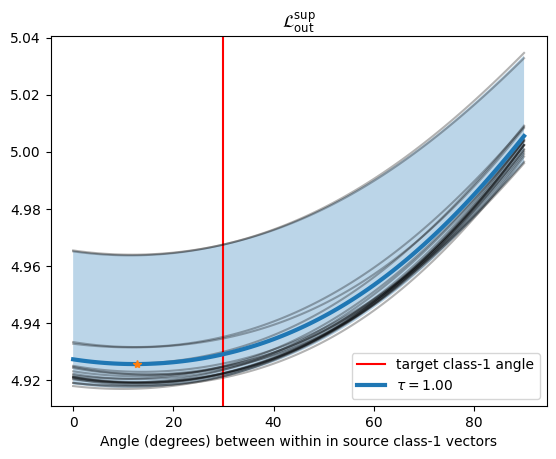

In [ ]:
for method_i,loss in enumerate(losses):
    for tau_j,tau in enumerate(sets_of_taus[method_i]):
        fig = plt.figure()
        v = np.mean(values[:,:,method_i,tau_j],axis=0).squeeze()
        plt.axvline(fixed_angle,color='r',label='target class-1 angle')

        plt.plot(180/np.pi*thetas,values[:,:,method_i,tau_j].T,'k',alpha=0.3)
        v = np.mean(values[:,:,method_i,tau_j],axis=0).squeeze()
        if tau is not None:
            plt.plot(180/np.pi*thetas,v,lw=3,label=r'$\tau=$'+f'{tau:.2f}')
        else:
            plt.plot(180/np.pi*thetas,v,lw=3)

        plt.legend()
        vl = np.quantile(values[:,:,method_i,tau_j],0.025,axis=0).squeeze()
        vu = np.quantile(values[:,:,method_i,tau_j],1-0.025,axis=0).squeeze()
        plt.fill_between(180/np.pi*thetas,vl,vu, alpha=0.3, label='95% Confidence Interval')
        plt.plot(180/np.pi*thetas[np.argmin(v)],np.min(v),'*')
        plt.xlabel('Angle (degrees) between within in source class-1 vectors')
        plt.title(loss_names[method_i])
        if ((loss_names[method_i]=='CC-EBSW') or (loss_names[method_i]=='CC-EBSW' )):
            plt.savefig(f"{method_i}_at30_imbalanced_3D.pdf")
        if tau==0.1:
            plt.savefig(f"{method_i}_{tau:.2f}_at30_imbalanced_3D.pdf")


In [ ]:
# In this case the target is bimodal with fixed angle of 30 degrees
# but the within class distribution is different between source and target
p0 = 0.5
p1 = 0.5
p2 = 0.5
p3 = 0.75 #majority are of the aligned

values = np.zeros((n_monte,len(thetas),len(losses),len(taus)))

for outer,theta in enumerate(thetas):
    x2 = np.array([0,np.cos(theta),np.sin(theta)])
    X_source = np.vstack((x0,x1,x2))
    X_target = np.vstack((x0,x1,x3))


    rng = np.random.default_rng(0)
    for monte in range(n_monte):
        idx = rng.choice(3,size=N,p=[p0,(1-p0)*p1,(1-p0)*p2])
        y = 1*(idx>0)
        X1 = X_source[idx] # first copy

        idx1 = rng.choice(3,size=N,p=[0,p3,1-p3])#  target given class 1
        X2 = X_target[idx1] # indpendent from class 1
        X2[y==0]=x0 # rewrite with class 0
        for i,loss in enumerate(losses):
            for j,tau in enumerate(sets_of_taus[i]):
                values[monte,outer,i,j] = loss(X1,X2,y,tau)



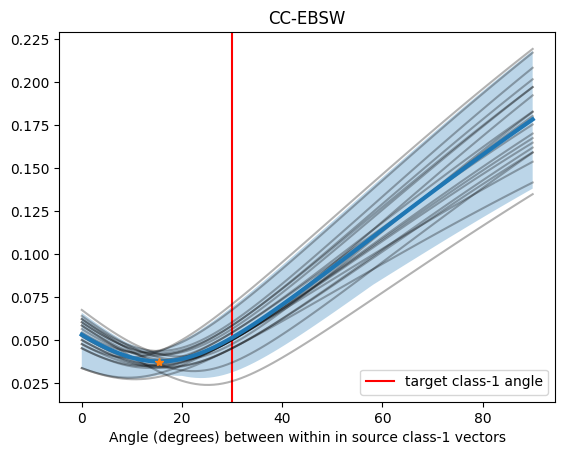

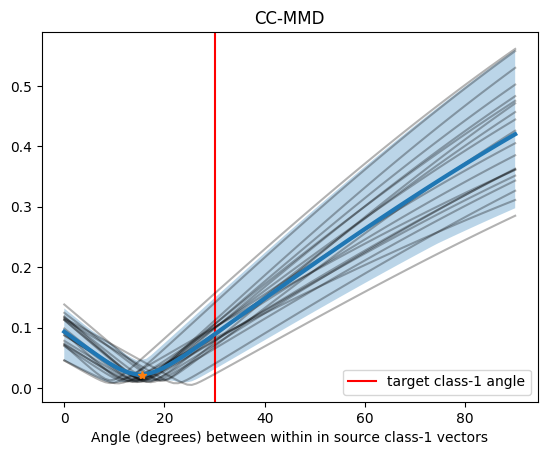

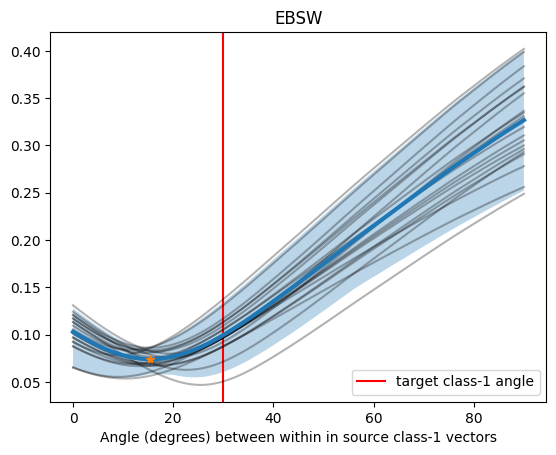

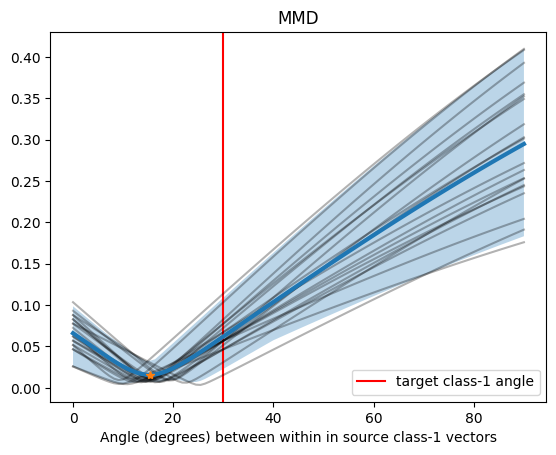

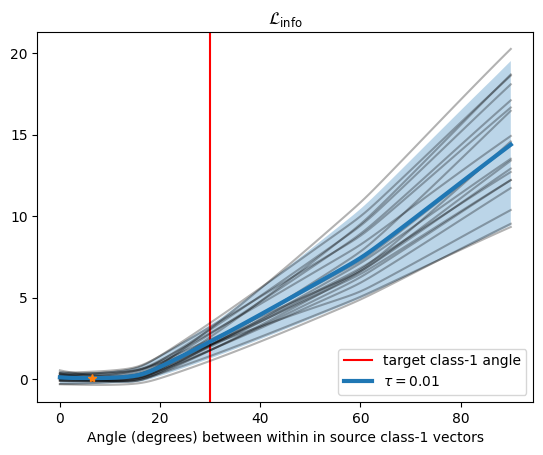

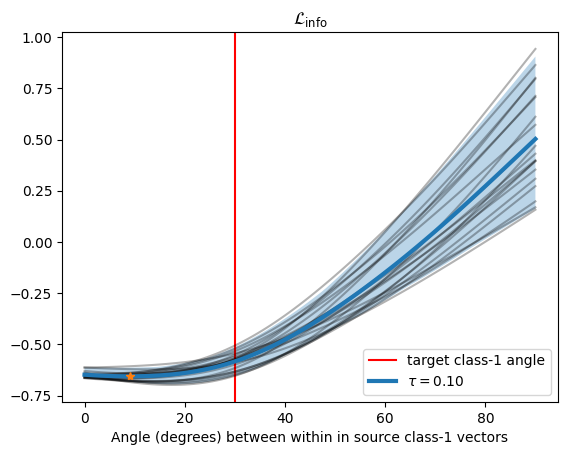

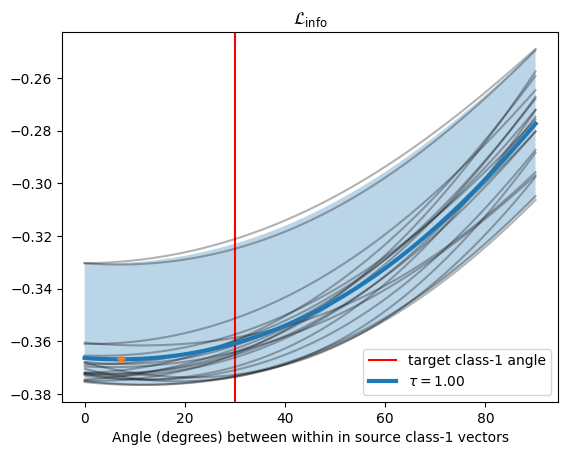

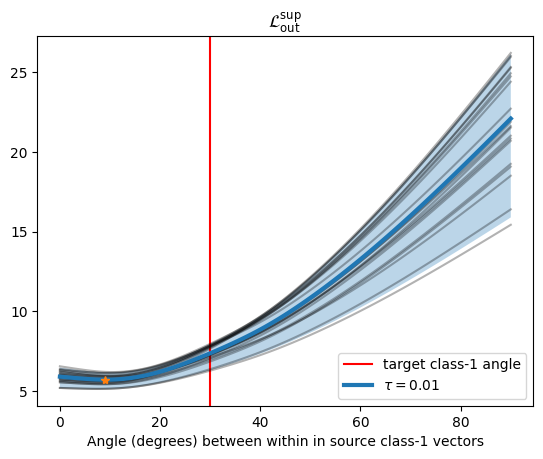

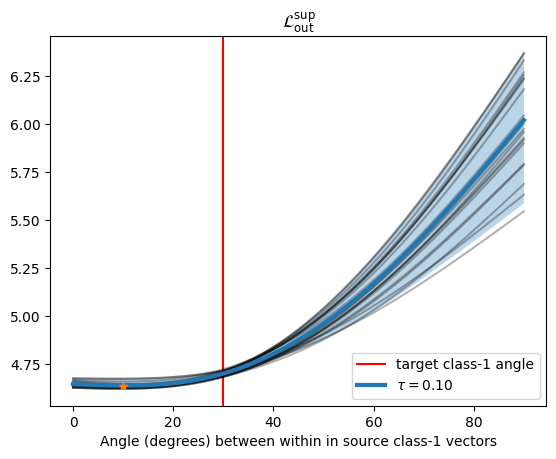

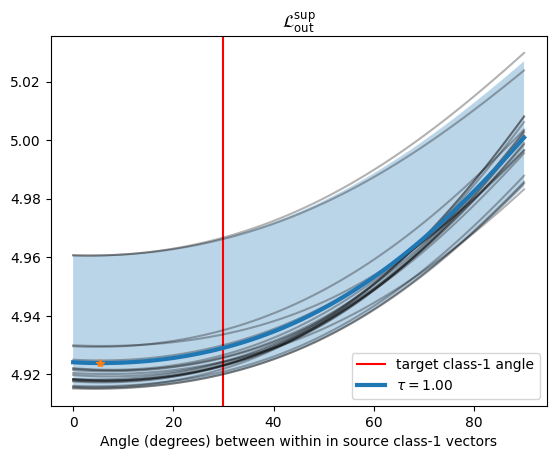

In [ ]:
for method_i,loss in enumerate(losses):
    for tau_j,tau in enumerate(sets_of_taus[method_i]):
        fig = plt.figure()
        v = np.mean(values[:,:,method_i,tau_j],axis=0).squeeze()
        plt.axvline(fixed_angle,color='r',label='target class-1 angle')

        plt.plot(180/np.pi*thetas,values[:,:,method_i,tau_j].T,'k',alpha=0.3)
        v = np.mean(values[:,:,method_i,tau_j],axis=0).squeeze()
        if tau is not None:
            plt.plot(180/np.pi*thetas,v,lw=3,label=r'$\tau=$'+f'{tau:.2f}')
        else:
            plt.plot(180/np.pi*thetas,v,lw=3)

        plt.legend()
        vl = np.quantile(values[:,:,method_i,tau_j],0.025,axis=0).squeeze()
        vu = np.quantile(values[:,:,method_i,tau_j],1-0.025,axis=0).squeeze()
        plt.fill_between(180/np.pi*thetas,vl,vu, alpha=0.3, label='95% Confidence Interval')
        plt.plot(180/np.pi*thetas[np.argmin(v)],np.min(v),'*')
        plt.xlabel('Angle (degrees) between within in source class-1 vectors')
        plt.title(loss_names[method_i])
